# Домашнее задание №6.


1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?
Напишите свои выводы.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import numpy as np
import tensorflow as tf
import cv2
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [55]:
# Путь к папкам с изображениями и масками на Google Диске
test_images_folder = "/content/drive/MyDrive/SegNet-Tutorial-master/CamVid/test"
test_masks_folder = "/content/drive/MyDrive/SegNet-Tutorial-master/CamVid/testannot"

train_images_folder = "/content/drive/MyDrive/SegNet-Tutorial-master/CamVid/train"
train_masks_folder = "/content/drive/MyDrive/SegNet-Tutorial-master/CamVid/trainannot"

val_images_folder = "/content/drive/MyDrive/SegNet-Tutorial-master/CamVid/val"
val_masks_folder = "/content/drive/MyDrive/SegNet-Tutorial-master/CamVid/valannot"

# Проверка содержимого папок с обучающими данными
train_images_list = os.listdir(train_images_folder)
train_masks_list = os.listdir(train_masks_folder)

# Проверка содержимого папок с валидационными данными
val_images_list = os.listdir(val_images_folder)
val_masks_list = os.listdir(val_masks_folder)

# Проверка содержимого папок с тестовыми данными
test_images_list = os.listdir(test_images_folder)
test_masks_list = os.listdir(test_masks_folder)

# Вывод списка файлов для каждой папки
print("Содержимое папки с обучающими изображениями:", train_images_list)
print("Содержимое папки с обучающими масками:", train_masks_list)
print("Содержимое папки с валидационными изображениями:", val_images_list)
print("Содержимое папки с валидационными масками:", val_masks_list)
print("Содержимое папки с тестовыми изображениями:", test_images_list)
print("Содержимое папки с тестовыми масками:", test_masks_list)


Содержимое папки с обучающими изображениями: ['0006R0_f01770.png', '0016E5_07530.png', '0016E5_01050.png', '0016E5_02070.png', '0001TP_008070.png', '0016E5_07740.png', '0016E5_07290.png', '0016E5_02310.png', '0016E5_05340.png', '0001TP_007830.png', '0001TP_007350.png', '0006R0_f02820.png', '0016E5_07080.png', '0016E5_04560.png', '0006R0_f01170.png', '0006R0_f01920.png', '0016E5_07140.png', '0016E5_08640.png', '0001TP_007050.png', '0016E5_08280.png', '0016E5_00690.png', '0016E5_00780.png', '0016E5_04770.png', '0016E5_05160.png', '0016E5_01830.png', '0016E5_07230.png', '0006R0_f02940.png', '0016E5_08520.png', '0016E5_01920.png', '0006R0_f01590.png', '0006R0_f03510.png', '0016E5_00510.png', '0016E5_04650.png', '0001TP_007200.png', '0006R0_f02130.png', '0016E5_00990.png', '0006R0_f01260.png', '0016E5_06810.png', '0006R0_f03600.png', '0006R0_f03000.png', '0006R0_f02760.png', '0006R0_f03870.png', '0016E5_00600.png', '0016E5_06840.png', '0006R0_f02010.png', '0016E5_02100.png', '0001TP_007530.

In [100]:
# Получаем список файлов в папке с изображениями
print("Файлы в папке с изображениями:")
print(os.listdir(train_images_folder))

# Получаем список файлов в папке с масками
print("\nФайлы в папке с масками:")
print(os.listdir(train_masks_folder))

Файлы в папке с изображениями:
['0006R0_f01770.png', '0016E5_07530.png', '0016E5_01050.png', '0016E5_02070.png', '0001TP_008070.png', '0016E5_07740.png', '0016E5_07290.png', '0016E5_02310.png', '0016E5_05340.png', '0001TP_007830.png', '0001TP_007350.png', '0006R0_f02820.png', '0016E5_07080.png', '0016E5_04560.png', '0006R0_f01170.png', '0006R0_f01920.png', '0016E5_07140.png', '0016E5_08640.png', '0001TP_007050.png', '0016E5_08280.png', '0016E5_00690.png', '0016E5_00780.png', '0016E5_04770.png', '0016E5_05160.png', '0016E5_01830.png', '0016E5_07230.png', '0006R0_f02940.png', '0016E5_08520.png', '0016E5_01920.png', '0006R0_f01590.png', '0006R0_f03510.png', '0016E5_00510.png', '0016E5_04650.png', '0001TP_007200.png', '0006R0_f02130.png', '0016E5_00990.png', '0006R0_f01260.png', '0016E5_06810.png', '0006R0_f03600.png', '0006R0_f03000.png', '0006R0_f02760.png', '0006R0_f03870.png', '0016E5_00600.png', '0016E5_06840.png', '0006R0_f02010.png', '0016E5_02100.png', '0001TP_007530.png', '0016E5_

In [ ]:
def load_data_from_folders(images_folder, masks_folder):
    images = []
    masks = []

    if not os.path.exists(images_folder):
        raise ValueError("Images folder not found: " + images_folder)
    if not os.path.exists(masks_folder):
        raise ValueError("Masks folder not found: " + masks_folder)

    for img_name in os.listdir(images_folder):
        img_path = os.path.join(images_folder, img_name)
        mask_path = os.path.join(masks_folder, img_name.split('.')[0] + '_mask.png')
        if os.path.isfile(img_path) and os.path.isfile(mask_path):
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            images.append(image)
            masks.append(mask)
        else:
            print("Files not found for:", img_name)

    if len(images) == 0 or len(masks) == 0:
        raise ValueError("No images or masks found in the provided folders")

    return np.array(images), np.array(masks)

# Пути к папкам с данными
train_images_folder = "/content/drive/MyDrive/SegNet-Tutorial-master/CamVid/train"
train_masks_folder = "/content/drive/MyDrive/SegNet-Tutorial-master/CamVid/trainannot"

val_images_folder = "/content/drive/MyDrive/SegNet-Tutorial-master/CamVid/val"
val_masks_folder = "/content/drive/MyDrive/SegNet-Tutorial-master/CamVid/valannot"

# Загрузка данных
train_images, train_masks = load_data_from_folders(train_images_folder, train_masks_folder)
val_images, val_masks = load_data_from_folders(val_images_folder, val_masks_folder)

# Нормализация данных
train_images = train_images / 255.0
train_masks = train_masks / 255.0

val_images = val_images / 255.0
val_masks = val_masks / 255.0

# Определение архитектуры U-Net
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Сжимающий путь (кодировщик)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Расширяющий путь (декодировщик)
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Создание модели U-Net
model = unet()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(train_images, train_masks, validation_data=(val_images, val_masks), batch_size=8, epochs=20)

# Сохранение модели
model.save("unet_model.h5")


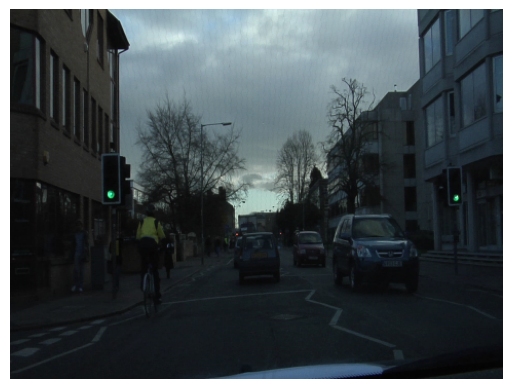

In [80]:
# Путь к изображению
image_path = "/content/drive/MyDrive/SegNet-Tutorial-master/CamVid/test/0001TP_008550.png"

# Загрузка изображения с помощью OpenCV
image = cv2.imread(image_path)

# Показать изображение
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
